# Evaluate the Relative Risk of Covid-19 death in states with no mask mandate vs. states with mask mandates over time

## BLUF (bottom line up front): 
## In October, residents in states without mask mandates were about 70% more likely to die of Covid-19 than residents of states with mask mandates.




### This analysis utilizes data from the Johns Hopkins University Github and an epidemiological concept known as Relative Risk Ratios to extimate the comparative probabilities of Covid-19 deaths between the two groups.
### JHU data: https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv
### AARP Mask Mandate data: https://www.aarp.org/health/healthy-living/info-2020/states-mask-mandates-coronavirus.html 
### County population 2019 data: https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-total.html![image.png](attachment:image.png)

### CDC Relative Risk Ratio calculation methodology: Principles of Epidemiology in Public Health Practice, Third Edition An Introduction to Applied Epidemiology and Biostatistics (https://www.cdc.gov/csels/dsepd/ss1978/lesson3/section5.html)

### Author: Alex Rich, MPH https://www.linkedin.com/in/alex-rich-940651a8/
### alex.rich@unc.edu

### I'm a former Air Force special operations pilot and crash investigator with a Masters in Public Health from Yale university.  I'm currently completing a PhD in health informatics at UNC Chapel Hill.  I look at public health crises with the tools of aviation safety, focusing on data analysis and visual communication.

In [3]:
import os
import wget
import pandas as pd
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
# Python version 3.7.3
## Package Versions:
# wget==3.2
# pandas==1.1.1
#

In [4]:
# Check package versions:
# import pkg_resources
# pkg_resources.get_distribution('pandas').version

## Update file of covid deaths from JHU Github

In [5]:
fpData = os.getcwd()+'/data/'
## Get daily update of hopkins time series file for confirmed US cases
wget.download('https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv',\
              out = fpData +'covid_hopkins_overTime_DEATHS.csv')
## if file saves as a ____(01).csv, delete the old file and rename new to "covid_hopkins_overTime_CONFIRMED.csv"
if os.path.exists(fpData + "covid_hopkins_overTime_DEATHS (1).csv"):
    os.remove(fpData + "covid_hopkins_overTime_DEATHS.csv")
    os.rename(fpData + "covid_hopkins_overTime_DEATHS (1).csv",fpData + "covid_hopkins_overTime_DEATHS.csv")
    

In [6]:
# Read in new US Confirmed Timeseries data

covidDeaths = pd.read_csv(fpData +'covid_hopkins_overTime_DEATHS.csv',dtype={'FIPS':str})
covidDeaths.FIPS = covidDeaths.FIPS.str.split('.').str[0].str.zfill(5)

# collect dates from timeseries file
dates = []
for i in covidDeaths.columns:
    if '/' in i:
        dates.append(i)
        
fipsList = covidDeaths[~covidDeaths.FIPS.isnull()].FIPS.unique().tolist()



## Load county population estimates for 2019 from US census file

In [7]:
countyPops = pd.read_csv('/Users/alex/Documents/Compare Hopkins and NYT/co-est2019-alldata.csv',encoding='Latin1',\
                        dtype={'STATE':str,'COUNTY':str})
countyPops['fips'] = countyPops.STATE + countyPops.COUNTY
countPops = countyPops[countyPops.COUNTY!='000']

In [8]:
covidDeaths = pd.merge(covidDeaths,countyPops[['fips','POPESTIMATE2019']],left_on='FIPS',right_on='fips',how='left')

In [9]:
covidDeaths['state'] = covidDeaths.Province_State.str.lower()

In [16]:
dates = []
for d in covidDeaths.columns:
    if '/' in d:
        dates.append(d)

## Load .csv of mask mandate data derrived from AARP website

In [46]:
# States with No Mask Mandates as of the end of October
# Read in .csv file derrived from https://www.aarp.org/health/healthy-living/info-2020/states-mask-mandates-coronavirus.html accessed on 2 nov
stateMasks = pd.read_csv(os.getcwd()+'/data/stateMaskRegs.csv')
stateMasks.dateOfReg = pd.to_datetime(stateMasks.dateOfReg)
stateMasks.dateOfReg.fillna(dt.datetime(2030,1,1,0,0),inplace=True)
noMasks = stateMasks[stateMasks.maskReg=='no'].state.tolist()



In [11]:
# define function for getting last day of month
# credit: augustomen on stackoverflow https://stackoverflow.com/questions/42950/how-to-get-the-last-day-of-the-month
def last_day_of_month(any_day):
    # this will never fail
    # get close to the end of the month for any day, and add 4 days 'over'
    next_month = any_day.replace(day=28) + dt.timedelta(days=4)
    # subtract the number of remaining 'overage' days to get last day of current month, or said programattically said, the previous day of the first of next month
    return next_month - dt.timedelta(days=next_month.day)

In [67]:
# Function for creating dataframe of monthly relative risk ratios for covid death, no-mask-mandate states vs. all others
def stateDeathRR(listOfStatesOfInterest):
    rrList = []
    # Iterate through each month (march through october)
    try:
        for month in range(3, 12):
            endDate = last_day_of_month(dt.date(2020, (month), 1))
            endOfMonth = endDate.strftime('%-m/%-d/%y')
            lastMonth = last_day_of_month(dt.date(2020, (month-1), 1)).strftime('%-m/%-d/%y')

        #     listOfStatesOfInterest = stateMasks[stateMasks.dateOfReg > endOfMonth].state.unique().tolist()
            exposedCases= covidDeaths[covidDeaths.state.isin(listOfStatesOfInterest)][endOfMonth].sum() - covidDeaths[covidDeaths.state.isin(listOfStatesOfInterest)][lastMonth].sum()

            exposedNotCases = covidDeaths[covidDeaths.state.isin(listOfStatesOfInterest)].POPESTIMATE2019.sum() - covidDeaths[covidDeaths.state.isin(listOfStatesOfInterest)][endOfMonth].sum()

            notExposedCases = covidDeaths[((~covidDeaths.state.isin(listOfStatesOfInterest)))][endOfMonth].sum() - covidDeaths[(~covidDeaths.state.isin(listOfStatesOfInterest))][lastMonth].sum()

            notExposedNotCases = covidDeaths[~covidDeaths.state.isin(listOfStatesOfInterest)].POPESTIMATE2019.sum() - covidDeaths[~covidDeaths.state.isin(listOfStatesOfInterest)][endOfMonth].sum()

            try:
                rr = (exposedCases / (exposedCases + exposedNotCases)) / (notExposedCases /(notExposedCases + notExposedNotCases))

            except:
                rr=0

            entry = {
                'month':month,
                'endDay':endDate,#dt.datetime(2020,month,1,0,0),
                'listOfStatesOfInteresttates':listOfStatesOfInterest,
                'noMaskCount':len(listOfStatesOfInterest),
                'a': exposedCases, # covid deaths in no-mask states in October
                'b':exposedNotCases, # living population in no-mask states as of 1 october who didn't die of Covid by 31 Oct
                'c':notExposedCases, # covid deaths in mask-mandate states in October
                'd':notExposedNotCases, # living popualtion in mask-mandate states as of 1 October who didn't die of Covid by 31 Oct
                "relative risk vs. nation":round(rr,2),
            }
            rrList.append(entry)
    except:
        if int(dates[-1].split('/')[1])>21:

            endOfMonth = dates[-1]
            lastMonth = last_day_of_month(dt.date(2020, (month-1), 1)).strftime('%-m/%-d/%y')
            print(lastMonth)

            exposedCases= covidDeaths[covidDeaths.state.isin(listOfStatesOfInterest)][endOfMonth].sum() - covidDeaths[covidDeaths.state.isin(listOfStatesOfInterest)][lastMonth].sum()

            exposedNotCases = covidDeaths[covidDeaths.state.isin(listOfStatesOfInterest)].POPESTIMATE2019.sum() - covidDeaths[covidDeaths.state.isin(listOfStatesOfInterest)][endOfMonth].sum()

            notExposedCases = covidDeaths[((~covidDeaths.state.isin(listOfStatesOfInterest)))][endOfMonth].sum() - covidDeaths[(~covidDeaths.state.isin(listOfStatesOfInterest))][lastMonth].sum()

            notExposedNotCases = covidDeaths[~covidDeaths.state.isin(listOfStatesOfInterest)].POPESTIMATE2019.sum() - covidDeaths[~covidDeaths.state.isin(listOfStatesOfInterest)][endOfMonth].sum()

            try:
                rr = (exposedCases / (exposedCases + exposedNotCases)) / (notExposedCases /(notExposedCases + notExposedNotCases))

            except:
                rr=0

            entry = {
                'month':month,
                'endDay':dt.datetime.strptime(endOfMonth,'%m/%d/%y'),#dt.datetime(2020,month,1,0,0),
                'listOfStatesOfInteresttates':listOfStatesOfInterest,
                'noMaskCount':len(listOfStatesOfInterest),
                'a': exposedCases, # covid deaths in no-mask states in October
                'b':exposedNotCases, # living population in no-mask states as of 1 october who didn't die of Covid by 31 Oct
                'c':notExposedCases, # covid deaths in mask-mandate states in October
                'd':notExposedNotCases, # living popualtion in mask-mandate states as of 1 October who didn't die of Covid by 31 Oct
                "relative risk vs. nation":round(rr,2),
            }
            rrList.append(entry)

    # print most recent risk ratio for covid deaths, no-mask-mandate states vs. mask-mandate states
    print(round(rr,2))
    return(rrList)

In [68]:
deathRisk = pd.DataFrame(stateDeathRR(noMasks))

10/31/20
1.16


In [69]:
stateDeathRR(stateMasks[stateMasks.maskReg=='yes'].state.tolist())

10/31/20
0.83


[{'month': 3,
  'endDay': datetime.date(2020, 3, 31),
  'listOfStatesOfInteresttates': ['connecticut',
   'delaware',
   'new york',
   'maine',
   'massachusetts',
   'rhode island',
   'new mexico',
   'new jersey',
   'virginia',
   'california',
   'north carolina',
   'nevada',
   'washington',
   'oregon',
   'pennsylvania',
   'kansas',
   'texas',
   'west virginia',
   'kentucky',
   'louisiana',
   'montana',
   'alabama',
   'arkansas',
   'colorado',
   'dc',
   'ohio',
   'minnesota',
   'illinois',
   'indiana',
   'maryland',
   'vermont',
   'wisconsin',
   'michigan',
   'north dakota',
   'hawaii'],
  'noMaskCount': 35,
  'a': 4891,
  'b': 249469394.0,
  'c': 380,
  'd': 78764857.0,
  'relative risk vs. nation': 4.06},
 {'month': 4,
  'endDay': datetime.date(2020, 4, 30),
  'listOfStatesOfInteresttates': ['connecticut',
   'delaware',
   'new york',
   'maine',
   'massachusetts',
   'rhode island',
   'new mexico',
   'new jersey',
   'virginia',
   'california',
   

In [57]:
# Make .csv to check math for Risk Ratio cacluations
covidDeaths[covidDeaths.state.isin(noMasks)][['Admin2','state','9/30/20','10/31/20','POPESTIMATE2019']].to_csv(os.getcwd()+'/no_mask_states_OctoberCovidDeaths.csv',index=False)


In [58]:
# Make .csv to check math for Risk Ratio cacluations

covidDeaths[(~covidDeaths.state.isin(noMasks))&(~covidDeaths.Province_State.isnull())][['Admin2','state','9/30/20','10/31/20','POPESTIMATE2019']].to_csv(os.getcwd()+'/MASK_states_OctoberCovidDeaths.csv',index=False)


In [59]:
# Calcualtions to check .csv against
deathRisk[deathRisk.month==10]

,month,endDay,noMaskStates,noMaskCount,a,b,c,d,relative risk vs. nation
7,10,2020-10-31,"[alaska, arizona, florida, georgia, hawaii, id...",16,7910,76219394.0,16018,251789002.0,1.63


In [60]:
deathRisk

,month,endDay,noMaskStates,noMaskCount,a,b,c,d,relative risk vs. nation
0,3,2020-03-31,"[alaska, arizona, florida, georgia, hawaii, id...",16,353,76269049.0,4918,251965202.0,0.24
1,4,2020-04-30,"[alaska, arizona, florida, georgia, hawaii, id...",16,4149,76264900.0,56550,251908652.0,0.24
2,5,2020-05-31,"[alaska, arizona, florida, georgia, hawaii, id...",16,4786,76260114.0,36917,251871735.0,0.43
3,6,2020-06-30,"[alaska, arizona, florida, georgia, hawaii, id...",16,4085,76256029.0,16028,251855707.0,0.84
4,7,2020-07-31,"[alaska, arizona, florida, georgia, hawaii, id...",16,9169,76246860.0,17137,251838570.0,1.77
5,8,2020-08-31,"[alaska, arizona, florida, georgia, hawaii, id...",16,11222,76235638.0,18369,251820201.0,2.02
6,9,2020-09-30,"[alaska, arizona, florida, georgia, hawaii, id...",16,8334,76227304.0,15181,251805020.0,1.81
7,10,2020-10-31,"[alaska, arizona, florida, georgia, hawaii, id...",16,7910,76219394.0,16018,251789002.0,1.63
8,11,2020-11-26,"[alaska, arizona, florida, georgia, hawaii, id...",16,8424,76210970.0,23903,251765099.0,1.16


# Plot the results

10/31/20
0.81
10/31/20
1.2


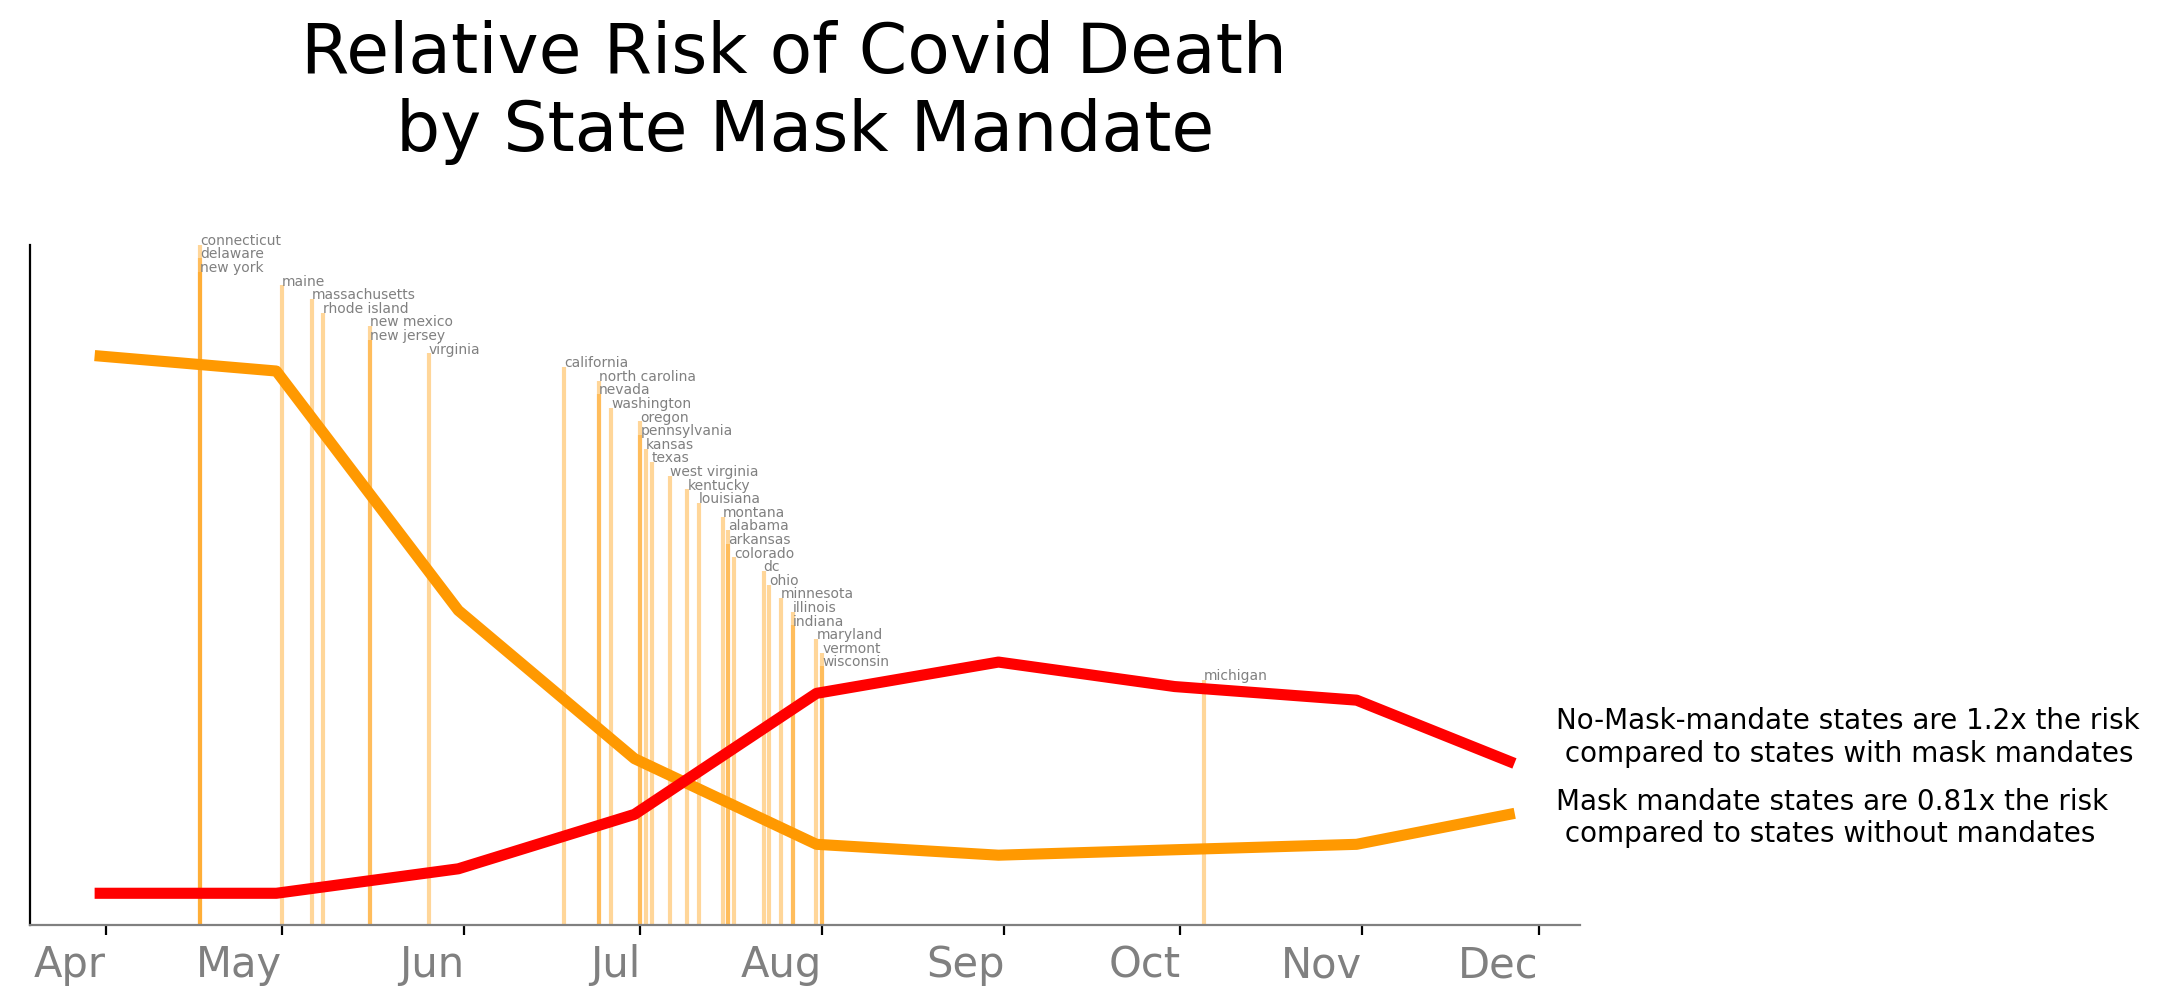

In [95]:
##
# Plot
##

# Plot states WITH mask mandates
#   * this line sets the states to count as "mask mandate states" ****
state = stateMasks[stateMasks.dateOfReg<dt.datetime(2020,11,1,0,0)].state.unique().tolist()
deathRR = pd.DataFrame(stateDeathRR(state))

countyColor = '#FF9901'

plt.figure(figsize=(10,5),dpi=200)
ax = plt.subplot(111)


deathRR.set_index('endDay')['relative risk vs. nation'].plot.line(linewidth=4,color=countyColor)

counter = 0
stateMasks = stateMasks.sort_values('dateOfReg',ascending=True)
for s in state:
    if stateMasks[stateMasks.state==s].dateOfReg.item() < dt.datetime(2020,12,1,0,0):
        plt.vlines(x = stateMasks[stateMasks.state==s].dateOfReg.item(),ymax =(5-counter*.1),ymin=0, color= countyColor, linestyle='-',alpha=0.4)
        plt.text(stateMasks[stateMasks.state==s].dateOfReg.item(),(5-counter*.1),s,fontsize=5,color='grey')
        counter = counter + 1

plt.title("Relative Risk of Covid Death \n by State Mask Mandate \n",fontsize=25)
# plt.title("Relative Risk of Covid Death," + state + " vs. Others",fontsize=20)
plt.xlabel('')


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
plt.yticks([])

# ax.spines['left'].set_color('darkgrey')
ax.spines['bottom'].set_color('grey')

# percInfectedList = weekly.perHundK.tolist()




# ax.tick_params(axis="y", labelsize=15,color='grey')

plt.minorticks_off()





state = noMasks

endRR = deathRR[deathRR.endDay == deathRR.endDay.max()]['relative risk vs. nation'].item()
labelText = "Mask mandate states are " + str(endRR) +"x the risk \n compared to states without mandates"
plt.text(dt.date(2020, 12, 4),deathRR[deathRR.endDay == deathRR.endDay.max()]['relative risk vs. nation'].item()-.2,labelText,horizontalalignment='left',fontsize=10)

# Plot states WITHOUT mask mandates
#   * this line sets the states to count as "no mask states" ****
state = stateMasks[stateMasks.dateOfReg>=dt.datetime(2020,11,1,0,0)].state.unique().tolist()
deathRR = pd.DataFrame(stateDeathRR(state))
deathRR.set_index('endDay')['relative risk vs. nation'].plot.line(linewidth=4,color='red')



endRR = deathRR[deathRR.endDay == deathRR.endDay.max()]['relative risk vs. nation'].item()
labelText = "No-Mask-mandate states are " + str(endRR) +"x the risk \n compared to states with mask mandates"
plt.text(dt.date(2020, 12, 4),deathRR[deathRR.endDay == deathRR.endDay.max()]['relative risk vs. nation'].item(),labelText,horizontalalignment='left',fontsize=10)





import math
def roundup(x):
    return int(math.ceil(x / 10.0)) * 10




plt.ylim(0,5)


plt.xlabel('')

# plt.yticks(np.arange(0,200, 190))
# plt.ylim(0,140)
# plt.yticks(np.arange(0,140, 130))

# fp = os.getcwd() + '/plots/'+location + '.png'
# plt.savefig(fp,bbox_inches="tight")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.tick_params(axis="x", labelsize=15,labelcolor='grey',rotation=0)

fp = os.getcwd() + '/maskMandatesAndDeathRisk_byState.png'

plt.savefig(fp,bbox_inches="tight")

plt.show()



# Make a QR Code

In [18]:
import qrcode

img = qrcode.make('https://github.com/alexF3/noMaskMandateRisk_oct20')

print(type(img))
print(img.size)
# <class 'qrcode.image.pil.PilImage'>
# (290, 290)

img.save(os.getcwd() +'/qrcode_noMaskRRdeath.png')

<class 'qrcode.image.pil.PilImage'>
(410, 410)
